<a href="https://colab.research.google.com/github/ridvanyigit/My-Projects/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
# Import essential libraries for data manipulation, visualization, scaling, clustering, and dimensionality reduction.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Colab notebooks
%matplotlib inline

In [151]:
# Load the dataset, create a copy to work on, and inspect the first few rows.

dataset = pd.read_csv("CC GENERAL.csv")
df = dataset.copy()

# Display first 5 rows of the dataset
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [152]:
# Understand the structure of the dataset, checking for null values and data types of each column.

df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


In [153]:
# Fill missing values in 'CREDIT_LIMIT' and 'MINIMUM_PAYMENTS' with their respective column means.

df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mean(), inplace=True)
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean(), inplace=True)

# Verify that there are no missing values left
df.isnull().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


In [154]:
# Drop the customer ID column, as it is not relevant for clustering.

df.drop("CUST_ID", axis=1, inplace=True)

In [155]:
# This function visualizes the distribution of a numerical column,
# with lines representing the mean, min, and max values for easy analysis.

def disvis(column):
    mean_ = df[column].mean()
    min_ = df[column].min()
    max_ = df[column].max()

    plt.figure(figsize=(6, 4))
    sns.histplot(df[column], bins=10, kde=True)

    plt.axvline(mean_, color='r', linestyle='--', label=f'Mean: {mean_:.2f}')
    plt.axvline(min_, color='g', linestyle='--', label=f'Min: {min_}')
    plt.axvline(max_, color='b', linestyle='--', label=f'Max: {max_}')

    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [156]:
# Detect and treat outliers using the Interquartile Range (IQR) method.
# Log transformation is applied to columns with outliers to reduce skewness.

numeric_df = df.select_dtypes(include='number')
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Count outliers in each numeric column
count_out = numeric_df[(numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))].count()
df_count_out = pd.DataFrame(count_out, columns=['count_out'])

# Filter only the columns with outliers
df_count_out = df_count_out[df_count_out["count_out"] != 0]

# Apply log transformation to reduce the impact of outliers
for i in df_count_out.index:
    df[i] = np.log(df[i] + 1)

In [157]:
# After applying the log transformation, recheck for any remaining outliers.

numeric_df = df.select_dtypes(include='number')
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Recount outliers
count_out = numeric_df[(numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))].count()
df_count_out = pd.DataFrame(count_out, columns=['count_out'])
df_count_out

,count_out
BALANCE,132
BALANCE_FREQUENCY,1716
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,481
PURCHASES_INSTALLMENTS_FREQUENCY,0
CASH_ADVANCE_FREQUENCY,337


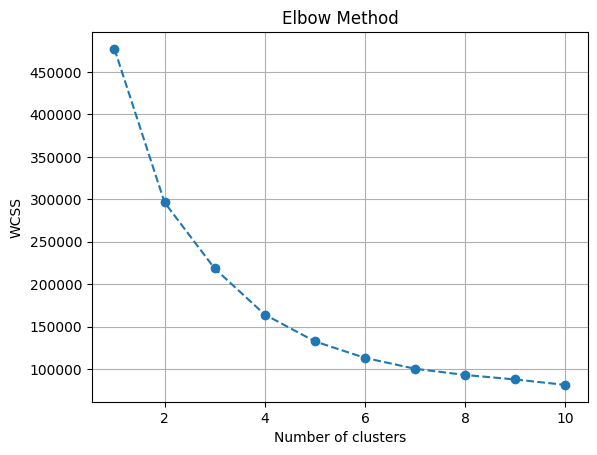

In [158]:
# Determine the optimal number of clusters using the Elbow method by plotting within-cluster sum of squares (WCSS).

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot WCSS for each cluster count
plt.plot(range(1, 11), wcss, marker='o', linestyle="--")
plt.grid()
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [159]:
# Scale the data to standardize the feature values and then reduce dimensions using PCA for better visualization.

scaler = StandardScaler()
ndf = scaler.fit_transform(df)

# Perform PCA to reduce the dimensions to 2 components
pca = PCA(n_components=2)
df_pca = pca.fit_transform(ndf)

In [160]:
# Based on the Elbow method, apply KMeans with 5 clusters, and assign cluster labels.

kmeans = KMeans(n_clusters=5, init='k-means++', n_init=20, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_pca)

# Add the PCA components for visualization
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

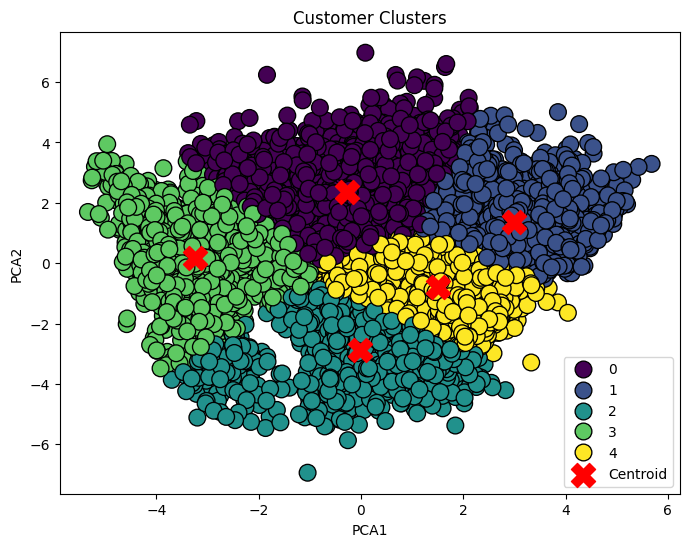

In [161]:
# Visualize the clusters in a 2D space using PCA components and show the centroids of each cluster.

centroids = df.groupby('Cluster').mean()[['PCA1', 'PCA2']].values

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=145, edgecolor='k')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroid', marker='X')

plt.legend()
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [162]:
# Evaluate the clustering model using Silhouette Score and Davies-Bouldin Score.

# Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters.
silhouette_avg = silhouette_score(ndf, df['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')

# Davies-Bouldin Score: Lower values indicate better clustering.
db_score = davies_bouldin_score(ndf, df['Cluster'])
print(f'Davies-Bouldin Score: {db_score:.3f}')

Silhouette Score: 0.186
Davies-Bouldin Score: 1.850
